## Import neccessary model

In [95]:
# !pip install torchinfo
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader, ConcatDataset, random_split
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import ToTensor
from PIL import Image
import os
# from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision import transforms
from torchinfo import summary
import timm
import random

## Preprocessing Dataset: Conver mask to BRG, Override get_item,..

In [96]:
class TransformDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = [f for f in os.listdir(self.img_dir) if os.path.isfile(os.path.join(self.img_dir, f))]

    def __len__(self):
        return len(self.images)

    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        red_mask = self.create_color_mask(image, (0, 100, 20), (10, 255, 255)) + \
                   self.create_color_mask(image, (160, 100, 20), (179, 255, 255))

        green_mask = self.create_color_mask(image, (36, 25, 25), (70, 255, 255))

        full_mask = np.bitwise_or(red_mask, green_mask).astype(np.uint8)
        full_mask = np.expand_dims(full_mask, axis=-1)

        return full_mask

    def create_color_mask(self, image, lower, upper):
        color_mask = cv2.inRange(image, np.array(lower), np.array(upper))
        color_mask[color_mask != 0] = 1
        return color_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        label = self.read_mask(label_path)
        image = cv2.resize(image, self.resize)

        # Apply the same augmentation to both image and label
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']

        label = label.permute(2, 0, 1).to(torch.float32) # for training 2,0,1

        return image, label

## Load dataset

In [97]:
image_path = []
TRAIN_DIR = '/kaggle/input/bkai-igh-neopolyp/train/train'
for root, dirs, files in os.walk(TRAIN_DIR):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

1000

In [98]:
mask_path = []
TRAIN_MASK_DIR = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt'
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    #iterate over 1000 masks
    for file in files:
        # obtain the path"
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)
len(mask_path)

1000

## Data Augmentation: Mix with original data, Normalize, Set batch size

In [99]:
# Adjusted values for augmentation
augment_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(), A.GaussNoise(), A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),
    A.CoarseDropout(p=0.2, max_height=35, max_width=35, fill_value=255),
    A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.15, brightness_coeff=1.5, p=0.09),
    A.RandomShadow(p=0.1),
    A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15),
    A.RandomCrop(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

normal_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

custom_dataset = TransformDataset(img_dir=TRAIN_DIR,
                                          label_dir=TRAIN_MASK_DIR,
                                          resize=(256, 256),
                                          transform=normal_transform)


# Set a random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
# Define the ratio of the dataset to be used for validation
validation_ratio = 0.1

# Calculate the number of samples for each split
dataset_size = len(custom_dataset)
validation_size = int(validation_ratio * dataset_size)
train_size = dataset_size - validation_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(custom_dataset, [train_size, validation_size])

# Create DataLoaders for training and validation
batch_size = 4
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Augment
AUG_train_dataset = TransformDataset(img_dir=TRAIN_DIR,
                                      label_dir=TRAIN_MASK_DIR,
                                      resize=(256, 256),
                                      transform=augment_transform)
aug_train_dataset, _ = random_split(AUG_train_dataset, [train_size, validation_size])
new_train_dataset = ConcatDataset([train_dataset, aug_train_dataset])

train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)

print('Augmented Trainset: ',new_train_dataset.__len__(),'/',train_dataset.__len__(),'\n', 'Valid Dataset: ',val_dataset.__len__())

Augmented Trainset:  1800 / 900 
 Valid Dataset:  100


Image:  torch.Size([3, 512, 512]) Label:  torch.Size([1, 512, 512])


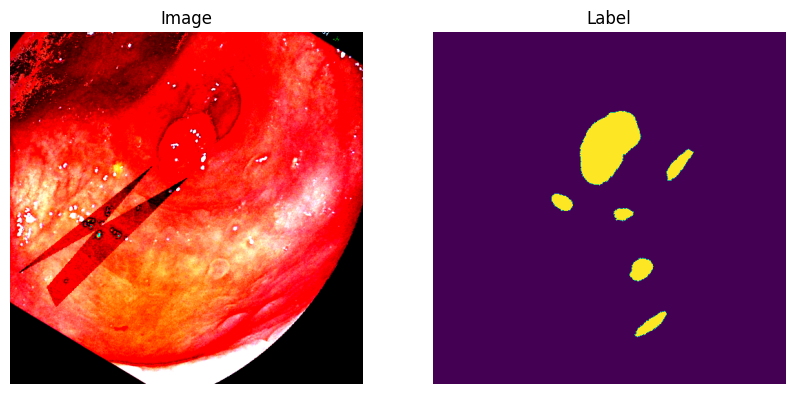

In [100]:
image,label = new_train_dataset[1230]
print('Image: ', image.shape, 'Label: ', label.shape) 

label_array = label.permute(1, 2, 0).numpy() # set 1,2,0 for show image
image_array = image.permute(1, 2, 0).numpy()
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_array)
axs[0].set_title('Image')
axs[0].axis('off')  

axs[1].imshow(label_array)
axs[1].set_title('Label')
axs[1].axis('off')  

plt.show()

## Encoder Block

## Decoder Block

## Bottleneck Block

## Full Unet

### Init Model Unet

In [101]:
!pip install segmentation-models-pytorch

In [102]:
torch.cuda.empty_cache()
# model = UNet(3)
import segmentation_models_pytorch as smp
model = smp.UnetPlusPlus(
    encoder_name="resnet34",      
    encoder_weights="imagenet",     
    in_channels=3,                 
    classes=3                       
)

### Setup hyperparameter for optimizer: Adam Optimizer

In [103]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

#### Load before continue training. Change something if needed

In [104]:
# checkpoint = torch.load('/kaggle/input/trained-model-1/colorization_model (6).pth')
# model.load_state_dict(checkpoint['model'])
# device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# model.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=checkpoint['learning_rate'])  # Thay đổi các tham số theo cấu hình của bạn
# # Nạp trạng thái của optimizer từ checkpoint
# optimizer.load_state_dict(checkpoint['optimizer'])

# optimizer.param_groups[0]['lr'] = 0.0001
# weight_decay = 0.000  # Adjust as needed
# # for param_group in optimizer.param_groups:
# #     param_group['weight_decay'] = weight_decay
# # Sau khi nạp trạng thái, đưa cả model và optimizer lên device
# model.to(device)
# for state in optimizer.state.values():
#     for k, v in state.items():
#         if isinstance(v, torch.Tensor):
#             state[k] = v.to(device)
# loss_value = checkpoint['loss']
# # print('Old optimizer: ',checkpoint['optimizer'])

# print(f"The loss from the checkpoint is: {loss_value:.10f}")

## Setup WanDB

In [105]:
import wandb
!wandb login '39dfa65a7ff4076b9db7aaeed60ce25894d086b6'

wandb.init(
    # set the wandb project where this run will be logged
    project="Polyp-DL",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "UNet++",
    "dataset": "Polyp",
    "epochs": 250,
    }
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Training Model

In [108]:
# Set the number of training epochs
num_epochs = 250

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size= 4, gamma=0.65)

# Move the model to the device (e.g., GPU)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

#Set the loss function
criterion = nn.CrossEntropyLoss()

# best_loss = checkpoint['loss']
best_loss = float('inf')

early_stopping_threshold = 8  # Stop if validation loss doesn't improve for this many epoch
early_stopping_counter = 0
best_val_loss = float('inf')

# change_learning_rate_threshold = 5
# learning_rate_counter = 0
# n=1

for epoch in range(num_epochs):
    model.train() # turn train mode
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        labels = labels.squeeze(dim=1).long()

        outputs = model(images)

        loss = criterion(outputs, labels)
        
#         l2_regularization = torch.tensor(0., device=device)
#         for param in model.parameters():
#             l2_regularization += torch.norm(param, 2)
#         loss += weight_decay * l2_regularization
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() # reset for new gradient 
        total_loss += loss.item()  # Accumulate the loss
        wandb.log({'loss_batch': loss.item()})
    # Update the learning rate
    scheduler.step()
    
#     if learning_rate_counter > change_learning_rate_threshold:
# #         scheduler.step()
#         optimizer.param_groups[0]['lr'] = 0.0001*0.7**n
#         n+=1
#         learning_rate_counter = 0

    # Calculate average loss for the epoch
    epoch_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")
    wandb.log({'loss': epoch_loss, 'learning rate': optimizer.param_groups[0]['lr']})
    
    model.eval()
    with torch.no_grad():
        # Compute validation loss
        val_loss = 0
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_labels = val_labels.squeeze(dim=1).long()
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()

        epoch_val_loss = val_loss / len(val_loader)
        print(f"Validation Loss: {epoch_val_loss:.10f}", f"Best Validation Loss:{best_val_loss:.10f}")
        wandb.log({"validation loss": epoch_val_loss})
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            checkpoint = { 
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': loss,
                'learning_rate': optimizer.param_groups[0]['lr']
            }
            save_path = f'colorization_model.pth'
            torch.save(checkpoint, save_path)
            print('Saved best model')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
#             learning_rate_counter += 1

        # If validation loss doesn't improve for a certain number of epochs, stop training
        if early_stopping_counter >= early_stopping_threshold:
            print(f"Early stopping after {epoch+1} epochs. Best Validation Loss: {best_val_loss:.10f}")
            break


Epoch [1/250], Loss: 0.0954476507
Validation Loss: 0.0787144950 Best Validation Loss:inf
Saved best model
Epoch [2/250], Loss: 0.0793310002
Validation Loss: 0.0742641480 Best Validation Loss:0.0787144950
Saved best model
Epoch [3/250], Loss: 0.0683259887
Validation Loss: 0.0817786802 Best Validation Loss:0.0742641480
Epoch [4/250], Loss: 0.0602085948
Validation Loss: 0.0594044412 Best Validation Loss:0.0742641480
Saved best model
Epoch [5/250], Loss: 0.0496247446
Validation Loss: 0.0471254995 Best Validation Loss:0.0594044412
Saved best model
Epoch [6/250], Loss: 0.0455602654
Validation Loss: 0.0477368870 Best Validation Loss:0.0471254995
Epoch [7/250], Loss: 0.0432211978
Validation Loss: 0.0543839596 Best Validation Loss:0.0471254995
Epoch [8/250], Loss: 0.0396082644
Validation Loss: 0.0395277863 Best Validation Loss:0.0471254995
Saved best model
Epoch [9/250], Loss: 0.0346472082
Validation Loss: 0.0350245629 Best Validation Loss:0.0395277863
Saved best model
Epoch [10/250], Loss: 0.0

KeyboardInterrupt: 

### Save Ouput

In [ ]:
!mkdir 
# !mkdir test_overlapmask

In [ ]:
trainsize = 256
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))
    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)    
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (trainsize, trainsize))
    transformed = normal_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    new_rgb_mask = np.zeros((*mask.shape, 3)).astype(np.uint8)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb_true = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("predict_mask/{}".format(i), mask_rgb)
#     print("processed ", img_path)
print("Loaded & Processed Test file")

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
#         print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/predict_mask' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'submission.csv', index=False)
print("Done")